In [2]:
using CABLAB
import Patchwork
Patchwork.load_js_runtime()

In this study we investigate the redundancy the different variables in each pixel. Therefore we calculate a linear dimensionality reduction (PCA) and check how many dimensions are needed to explain 90% of the variance of a cube that contained originally 6 variables.  First we check out the variables from the cube and add some processors, because we want to do a global study

In [2]:
c     = Cube("/home/jovyan/work/datacube/cablab-datacube-0.2.2/low-res/")

CABLAB data cube at /home/jovyan/work/datacube/cablab-datacube-0.2.2/low-res/
Spatial resolution:  1440x720 at 0.25 degrees.
Temporal resolution: 2001-01-01T00:00:00 to 2012-01-01T00:00:00 at 8daily time steps
Variables:           aerosol_optical_thickness_1610 aerosol_optical_thickness_550 aerosol_optical_thickness_555 aerosol_optical_thickness_659 aerosol_optical_thickness_865 air_temperature_2m black_sky_albedo burnt_area c_emissions country_mask evaporation evaporative_stress fractional_snow_cover gross_primary_productivity interception_loss land_surface_temperature latent_energy net_ecosystem_exchange open_water_evaporation ozone potential_evaporation precipitation root_moisture sensible_heat snow_sublimation snow_water_equivalent soil_moisture surface_moisture terrestrial_ecosystem_respiration transpiration water_mask water_vapour white_sky_albedo 


In [3]:
vars  = ["gross_primary_productivity","air_temperature_2m","latent_energy","root_moisture"
    ,"terrestrial_ecosystem_respiration","burnt_area","black_sky_albedo"];
cdata = getCubeData(c,variable=vars);

In [4]:
addprocs(10);

In [5]:
CABLAB.DAT.init_DATworkers();

We perform some gapfilling, because the pca does not work with gaps

In [6]:
@time cube_filled     = mapCube(gapFillMSC,cdata);

216.641179 seconds (22.46 M allocations: 881.555 MB, 0.21% gc time)


And we calculate the anomalies

In [7]:
@time cubeanom        = mapCube(removeMSC,cube_filled)

187.025950 seconds (4.87 M allocations: 160.798 MB, 0.05% gc time)


Temporary Data Cube with the following dimensions
Time                Axis with 506 Elements from 2001-01-01T00:00:00 to 2011-12-27T00:00:00
Lon                 Axis with 1440 Elements from -180.0 to 179.75
Lat                 Axis with 720 Elements from 90.0 to -89.75
Variable            Axis with elements: gross_primary_productivity air_temperature_2m latent_energy root_moisture terrestrial_ecosystem_respiration burnt_area black_sky_albedo 


In [8]:
@everywhere using MultivariateStats
@everywhere function sufficient_dimensions{T}(xout::AbstractArray{T}, xin::AbstractArray{T}, expl_var::Float64 = 0.95)
    if mapreduce(isnan,+,0,xin)>0
        return xout[1]=NaN
    end
    npoint, nvar = size(xin)
    for i in 1:nvar
        _sum  = _ssum = zero(eltype(xin))
        for j in 1:npoint
            _sum  += xin[j,i]
            _ssum += xin[j,i]^2
        end
        _mean  = _sum / npoint
        _smean = _ssum / npoint
        _std = sqrt(_smean - _mean^2 > 0.0 ? _smean-_mean^2 : zero(typeof(_mean)))
        if _std == 0
            _std = 1.0
            #warn("zero variance in column $i")
        end
        for j in 1:npoint
            xin[j,i] -= _mean
            xin[j,i] /= _std
        end
    end
    pca = fit(PCA, xin, pratio = 0.999, method = :svd)
    xout[1]  =
        findfirst(cumsum(principalvars(pca)) / tprincipalvar(pca) .> expl_var)
    xout[1]
end 
registerDATFunction(sufficient_dimensions,(TimeAxis,VariableAxis),(),inmissing=(:nan,),outmissing=:nan,no_ocean=1);

First we do the analysis on the original cube:

In [9]:
@time qualitypca=mapCube(sufficient_dimensions,cube_filled,0.90);

158.781010 seconds (3.43 M allocations: 166.411 MB, 0.05% gc time)


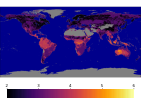

In [19]:
plotMAP(qualitypca,dmin=2,dmax=6)

And on the anomalies only:

In [11]:
qualitypcaanom=mapCube(sufficient_dimensions,cubeanom,0.90);

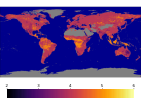

In [18]:
plotMAP(qualitypcaanom,dmin=2,dmax=6)

In [13]:
rmprocs(workers())

:ok